# Rivulet: U. S. EPA Air Quality System
_by Michelle H Wilkerson, Lucas Coletti_

## Purpose of this Notebook

This notebook was developed as part of NSF Grant 2445609 to support accessing and processing AirNow data for middle and high school classroom activities. It's written to be relatively accessible to beginners, but if you have not interacted with computational notebooks or python before you may find navigating this tool difficult. (Check out the Show Your Work project for a gentle introduction to computational notebooks for educators!)

Our project is focused on supporting data analysis and mechanistic reasoning in science education. In other words, we want students to learn how data provides information about _how scientific mechanisms work_, and how understanding scientific mechanisms can help them to _explain and interpret patterns in data_. This builds on a long history of research on complex systems and agent-based modeling, and more closely connects that work to current expansions of data analysis across subjects.

Here, we are focused on Air Quality as a phenomenon. While most students understand that poor Air Quality can impact health, they may not know that there are many different kinds of air pollution, each caused by different processes and chemicals. These are reflected by different patterns over the course of a day or year

This data tool allows users to connect to the Air Quality System API, search for air quality data streams in an area of interest, identify a date range of interest within that area, and then identifies which (if any) of the available data streams recorded observations for _both_ PM2.5 and O3 in that area and time range. These are two key pollutants that impact air quality and that tend to behave very differently over time. These kinds of datasets can serve as a launch to examining what AQ is and what are its underlying mechanistic and compositional complexities.

You are welcome to modify and adapt this script. You may find the AQS API documentation [here](https://aqs.epa.gov/aqsweb/documents/data_api.html) and the `pyaqsapi` documentation [here](https://usepa.github.io/pyaqsapi/) helpful.

# Part I: Connecting with AQS

Before you get started, you will need an AQS API Key. To get one, make a request using the url `https://aqs.epa.gov/data/api/signup?email=myemail@example.com` (replace myemail@example.com with your email). You will recieve a cute sounding API Key via email. Copy it and set EMAIL and API_KEY in the cell block below to your email and key from the service. (You can use the test email and key that are provided, however, the test account has a limited number of uses per day and may not work. Please register for an account if you would like to use the service.) If you need to reset your key, use this same url with the same email address.

In [2]:
%pip install pyaqsapi # python aqs helper

EMAIL = "test@aqs.api" #replace with your registered email
API_KEY = "test" # replace with your API key

10.12s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Ok, pyaqsapi is super friendly and gives us our data as dataframes. Let's take a look at the monitors available by site.

In [3]:
import pyaqsapi as aqs

try:
    aqs.aqs_credentials(username=EMAIL, key=API_KEY)
except Exception as e:
    print(f"Something didn't work: {e}")

Now, let's identify a location and time period that we want to explore. AQS can fetch data within a bounding box. Let's not get crazy - start with a relatively small bounding box (try one degree for an urban area) and get bigger if you need. (Tip: If you click on a location in Google Maps, you'll see the lat and long for that point in the URL.)

## Part II: Identifying a Focal Location and Date

This section allows you to specify a location and a date for which you would like to collect data. You'll need to know the approximate longitude and latitude of the region you are interested in. One easy way to do this is by asking Google "what is the longitude and latitude of [area]?" You will use the code in this section to use a minimum and maximum latitude and longitude to draw a bounding box around your location of interest. This will filter your future queries to focus only on air quality sensors found within that box. If you don't find any sensors, select a different location or increase the bounding box size.

In [4]:
# EDIT HERE: Define a bounding box around your
# target region. If it is densely populated, we suggest
# you start with a bounding box that is only one degree
# in area. 

min_lat = 37 # CHANGE TO YOUR MINIMUM LATITUDE
max_lat = 38 # CHANGE TO YOUR MAXIMUM LATITUDE

min_long = -122.5 # CHANGE TO YOUR MINIMUM LONGITUDE
max_long = -121.5

# this is unnecessary but sort of luxurious. let's map the box to
# make sure we're capturing what we want.

%pip install folium
import folium

bbox = [[min_lat, min_long], [max_lat, max_long]]

# Calculate the center of the box to position the map
map_center = [(bbox[0][0] + bbox[1][0]) / 2, (bbox[0][1] + bbox[1][1]) / 2]

# Create a Folium map object
m = folium.Map(location=map_center, zoom_start=8)

# Add a rectangle for the bounding box to the map
folium.Rectangle(
    bounds=bbox,
    color="#ff0000",        # Red border
    fill=True,
    fill_color="#ff7800",   # Orange fill
    fill_opacity=0.2
).add_to(m)

m

37.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
# EDIT HERE: identify a target date when something interesting
# was happening. Below, I define Jun 6 2023, a big wildfire smoke day in NY

from datetime import datetime, timedelta

target_date = "01-01-2020"
target_datetime = datetime.strptime(target_date, "%m-%d-%Y")

AQS has settings for different collections of parameters that reflect different "classes" of interest. For example, one parameter is SCHOOL AIR TOXICS which highligts 125 pollutants, or HAZARDOUS AIR POLLUTANTS with a total of 407 pollutants (!). Since we're only interested in O3 and PM, let's find a class that has those two and not much else so we're not taxing the system with our queries. AQI POLLUTANTS looks like a good one, it tracks the "big five" pollutants that are most commonly discussed along with a few other well known pollutants: 

In [6]:
try:
    parameter_list = aqs.aqs_parameters_by_class("AQI POLLUTANTS")
except Exception as e:
    print(f"Something didn't work: {e}")

parameter_list

,code,value_represented
0,42101,Carbon monoxide
1,42401,Sulfur dioxide
2,42602,Nitrogen dioxide (NO2)
3,44201,Ozone
4,81102,PM10 Total 0-10um STP
5,88101,PM2.5 - Local Conditions
6,88502,Acceptable PM2.5 AQI & Speciation Mass


From this list, you can select the specific AQI pollutant parameters that you want to fetch from any of the sequences below. We suggest Ozone (O3) and PM2.5, or Carbon monoxide (CO) and PM2.5.

# Part III: Identifying O3 and PM monitors

Let's start by getting all the active Ozone and PM2.5 monitors in the bounding box during this target date.

In [7]:
bdate = target_datetime
edate = target_datetime + timedelta(days=1)

monitors = aqs.bybox.monitors(
    parameter= "44201,88101", #44201 identifies ozone
    bdate=bdate, 
    edate=edate,
    minlat=min_lat,
    maxlat=max_lat,
    minlon=min_long,
    maxlon=max_long,
)

# Filter the monitors so we are showing only the ones that have all requested parameters
relevant_monitors = monitors.groupby(
    ['state_code','county_code','site_number']).filter( # make groups of each monitor
    lambda group: set(group['parameter_code']) == {'44201','88101'} # include only groups with both monitors
)


relevant_monitors[['state_code','county_code','site_number','address','city_name','county_name','state_name']].drop_duplicates()

,state_code,county_code,site_number,address,city_name,county_name,state_name
1,06,013,0002,2956-A TREAT BOULEVARD,Concord,Contra Costa,California
3,06,013,1004,"1865 D RUMRILL BLVD, San Pablo",San Pablo,Contra Costa,California
4,06,085,0005,158B JACKSON ST,San Jose,Santa Clara,California
5,06,001,0009,9925 International Blvd,Oakland,Alameda,California
8,06,075,0005,10 ARKANSAS ST.,San Francisco,San Francisco,California
9,06,001,0013,1 Bolivar Dr,Not in a City,Alameda,California
10,06,001,0007,793 Rincon Ave.,Livermore,Alameda,California
12,06,001,0011,1100 21st Street,Oakland,Alameda,California
21,06,081,1001,897 BARRON AVE.,Redwood City,San Mateo,California


Hopfully, the table above shows some candidate sites from which you can extract information about all of the pollutants you've identified. Let's choose one and take two weeks of sample data (that is the highest resolution of measurements available) around our target date.

In [12]:
# Identify the site number to focus on above. You'll need the 
# state_code, county_code, and site_number. I'm going to pick
# from the options above site 0011 with state_code = 34 and
# county_code = 023.	

# get the 2 week interval around the target
bdate = target_datetime - timedelta(weeks=1)
edate = target_datetime + timedelta(weeks=1)

aqdata = aqs.bysite.sampledata(parameter="44201,88101",
                      bdate=bdate,
                      edate=edate,
                      stateFIPS="06", # enter the state_code here
                      countycode="001", # enter the county_code here
                      sitenum="0011") # enter the site_number here

aqdata

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,date_local,...,detection_limit,uncertainty,qualifier,method_type,method,method_code,state,county,date_of_last_change,cbsa_code
0,06,001,0011,44201,1,37.814781,-122.282347,WGS84,Ozone,2020-01-01,...,0.005,None,None,FEM,INSTRUMENTAL - ULTRA VIOLET,047,California,Alameda,2020-07-16,41860
1,06,001,0011,44201,1,37.814781,-122.282347,WGS84,Ozone,2020-01-01,...,0.005,None,None,FEM,INSTRUMENTAL - ULTRA VIOLET,047,California,Alameda,2020-07-16,41860
2,06,001,0011,44201,1,37.814781,-122.282347,WGS84,Ozone,2020-01-01,...,0.005,None,None,FEM,INSTRUMENTAL - ULTRA VIOLET,047,California,Alameda,2020-07-16,41860
3,06,001,0011,44201,1,37.814781,-122.282347,WGS84,Ozone,2020-01-01,...,0.005,None,BD - Auto Calibration.,FEM,INSTRUMENTAL - ULTRA VIOLET,047,California,Alameda,2020-07-16,41860
4,06,001,0011,44201,1,37.814781,-122.282347,WGS84,Ozone,2020-01-01,...,0.005,None,None,FEM,INSTRUMENTAL - ULTRA VIOLET,047,California,Alameda,2020-07-16,41860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,06,001,0011,88101,3,37.814781,-122.282347,WGS84,PM2.5 - Local Conditions,2020-01-08,...,5.000,None,None,FEM,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,170,California,Alameda,2020-07-16,41860
380,06,001,0011,88101,3,37.814781,-122.282347,WGS84,PM2.5 - Local Conditions,2020-01-08,...,5.000,None,None,FEM,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,170,California,Alameda,2020-07-16,41860
381,06,001,0011,88101,3,37.814781,-122.282347,WGS84,PM2.5 - Local Conditions,2020-01-08,...,5.000,None,None,FEM,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,170,California,Alameda,2020-07-16,41860
382,06,001,0011,88101,3,37.814781,-122.282347,WGS84,PM2.5 - Local Conditions,2020-01-08,...,5.000,None,None,FEM,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,170,California,Alameda,2020-07-16,41860


Annoyingly, there is a local date and a local time, and a gmt date and a gmt time, but no datetime. Let's add that since otherwise we'll miss useful resoltuion in our data.

In [36]:
import pandas as pd

combined_series = aqdata['date_local'] + ' ' + aqdata['time_local']
aqdata['datetime_local'] = pd.to_datetime(combined_series, format="%Y-%m-%d %H:%M")

Let's take a look at the data we got to see what sorts of patterns are evident for this site at the specified time. 

10677.19s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 8.7 MB/s eta 0:00:00ta 0:00:01

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


KeyError: "['datetime_local'] not in index"

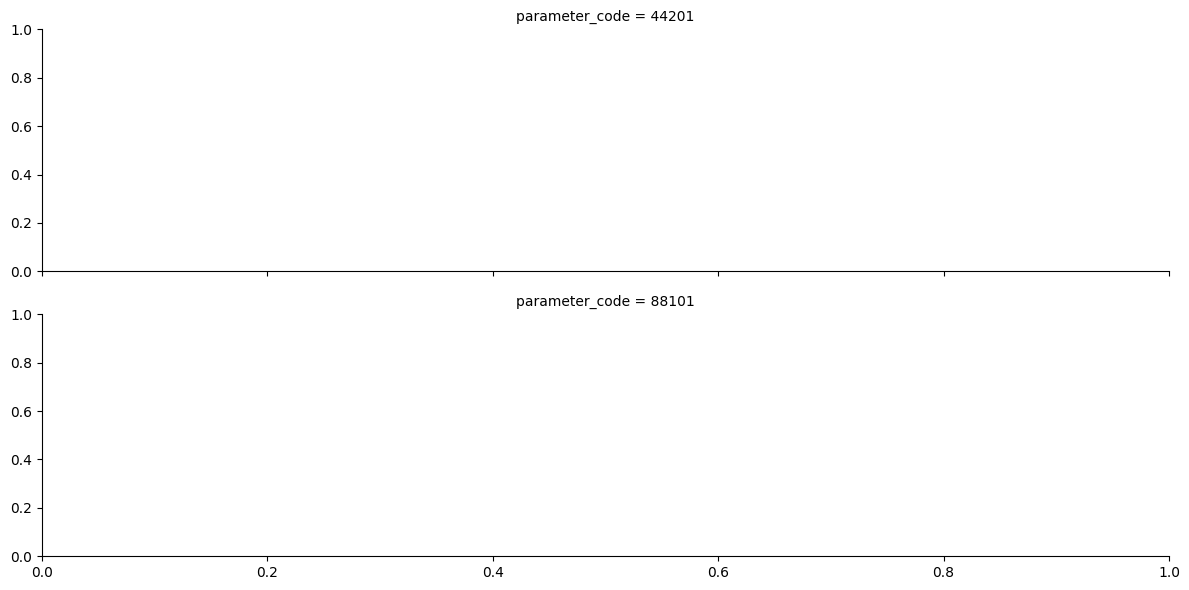

In [90]:
%pip install seaborn

#let's plot
import seaborn as sns

g = sns.FacetGrid(aqdata, 
                  row="parameter_code", 
                  aspect=4, # this makes the graphs 4x wider than they are tall
                  sharey=False) # this treats the scale for each pollutant separately

g.map(sns.lineplot, "datetime_local", "sample_measurement")

If this is looking good, then you're ready to expore to .csv to use it!

In [ ]:
aqdata.to_csv("filename.csv")

## Part IV: Finding Differences Among Neighbors

In addition to identifying specific events that help you explore differential emission patterns among pollutants, you may want to explore smaller but more robost differences in emissions at near neighbor locations. This may be useful to think about the impacts of particular natural (e.g. a coastal breeze or mountains) or man-made features (e.g. the presence of a freeway or factory) on local air quality patterns over longer periods of time.

This section helps you conduct a search within your defined bounding box  for the largest differences in mean concentrations between pollutants. 

NOTE: Right now I'm doing this for a one-month range around the specified datetime, but maybe talk to Helen or others about what kind of time range is reasonable. Let's identify the month first.

In [ ]:
# define the month around the target datetime specified above in Part II
bdate = target_datetime - timedelta(days=2)
edate = target_datetime + timedelta(days=2)

# define the pollutant you want to explore across sites. Below, we model with PM2.5
pollutants = "88101" ## TODO: Eventually, I think we can bring this out into the setup section since it's used everywhere

Now we are going to report the monitor sites within the bounding box that have the most dramatic differences in mean and range. (Need to think more carefully about what stats to compare here.)

So I am going to do a little hack. We don't have monthly aggregated data but we have quarterly. So look at the aggregates from the quarter and use that to decide for now.

In [ ]:
# For all sites within the bounding box
# get the aggregated stats by site of the requested pollutant(s) 

aqsummary = aqs.bysite.dailysummary(parameter="88101",
                      bdate=bdate,
                      edate=edate,
                      stateFIPS="06", # enter the state_code here
                      countycode="001", # enter the county_code here
                      sitenum="0009") # enter the site_number here

#NOTE - I believe this code is right, but it is hanging for me right now (9/17/25 around 3pm Pacific).
#It is also hanging on the corresponding GET request with a different API key so I don't think it's our problem.
#What I am trying to do is just see what this looks like for a site I know has the info and then I
#will loop through and get all sites in the bounding box to make the comparison.
#I'm going to move on to other tasks and come explore later

In [ ]:
aqsummary.columns

In [ ]:
# sites are uniquely ID'd by county code and site number
# turn this into a string so you can group site readings together

aqsummary.groupby().describe()

In [ ]:
aqsummary

# Credit

https://aqs.epa.gov/aqsweb/documents/about_aqs_data.html